# Test Scan merging

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

from planeslam.geometry.util import quat_to_rot_mat
from planeslam.general import plot_3D_setup
import planeslam.io as io
from planeslam.extraction import pc_to_planes
from planeslam.scan import pc_to_scan

%load_ext autoreload
%autoreload 2

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract scans from LiDAR point clouds

In [4]:
# Extract scans and planesets
num_scans = len(PC_data)
scans = num_scans * [None]
planesets = num_scans * [None]

for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])
    scans[i].transform(quat_to_rot_mat(drone_orientations[i,:]), drone_positions[i,:])

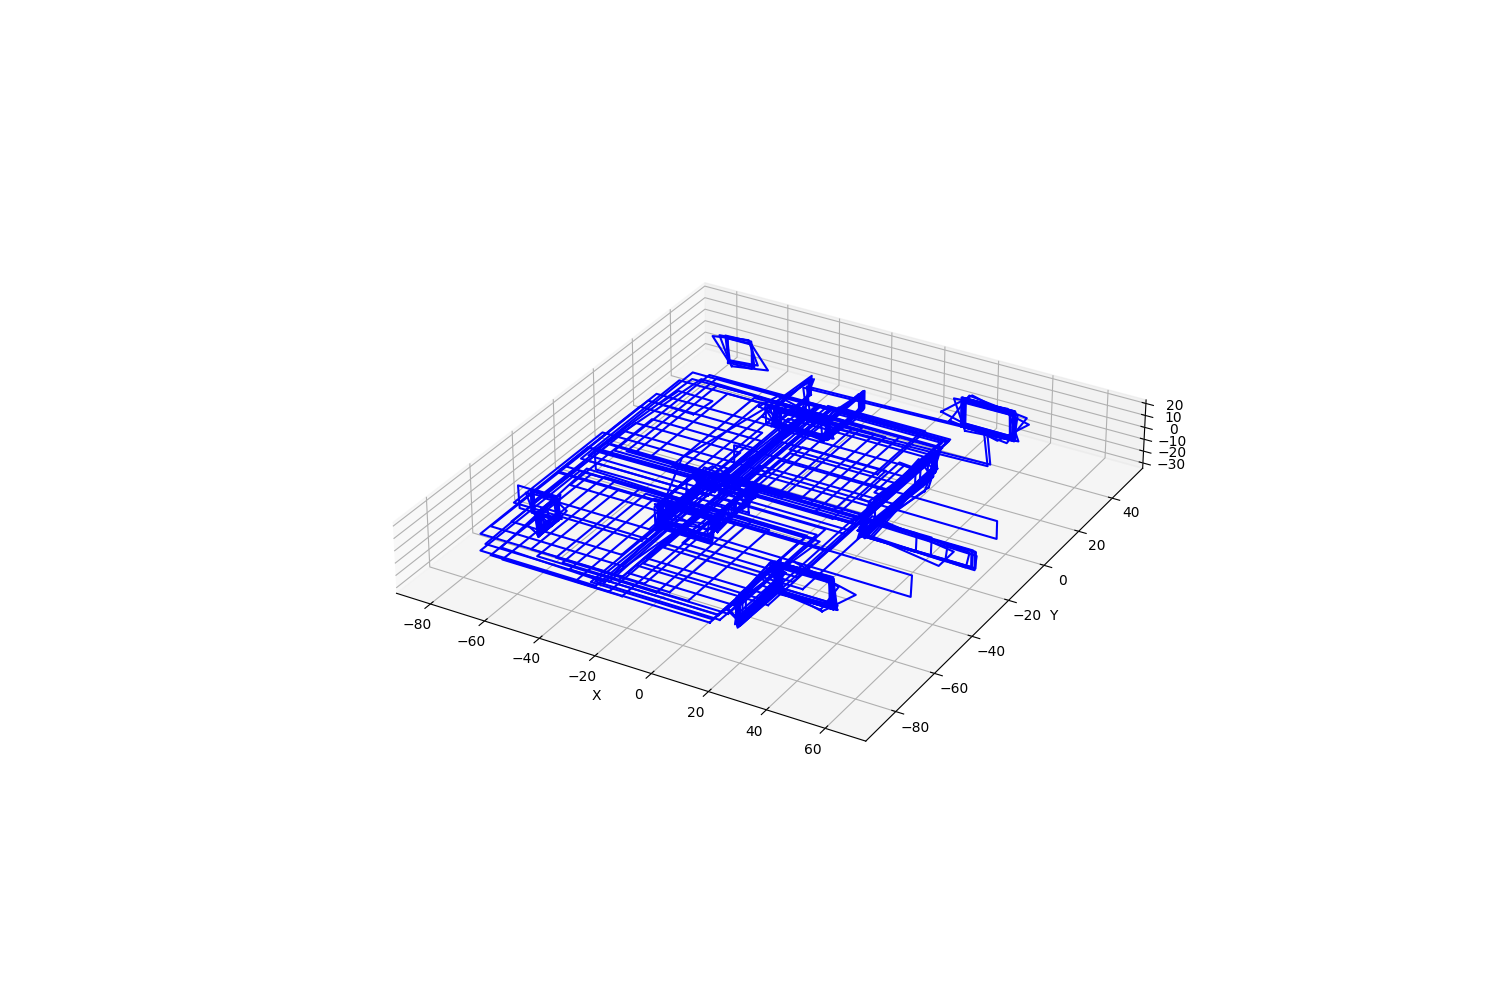

In [5]:
# Plot scans
ax = plot_3D_setup(PC_data[0])

for scan in scans:
    scan.plot(ax, color='b')

Merge Scans

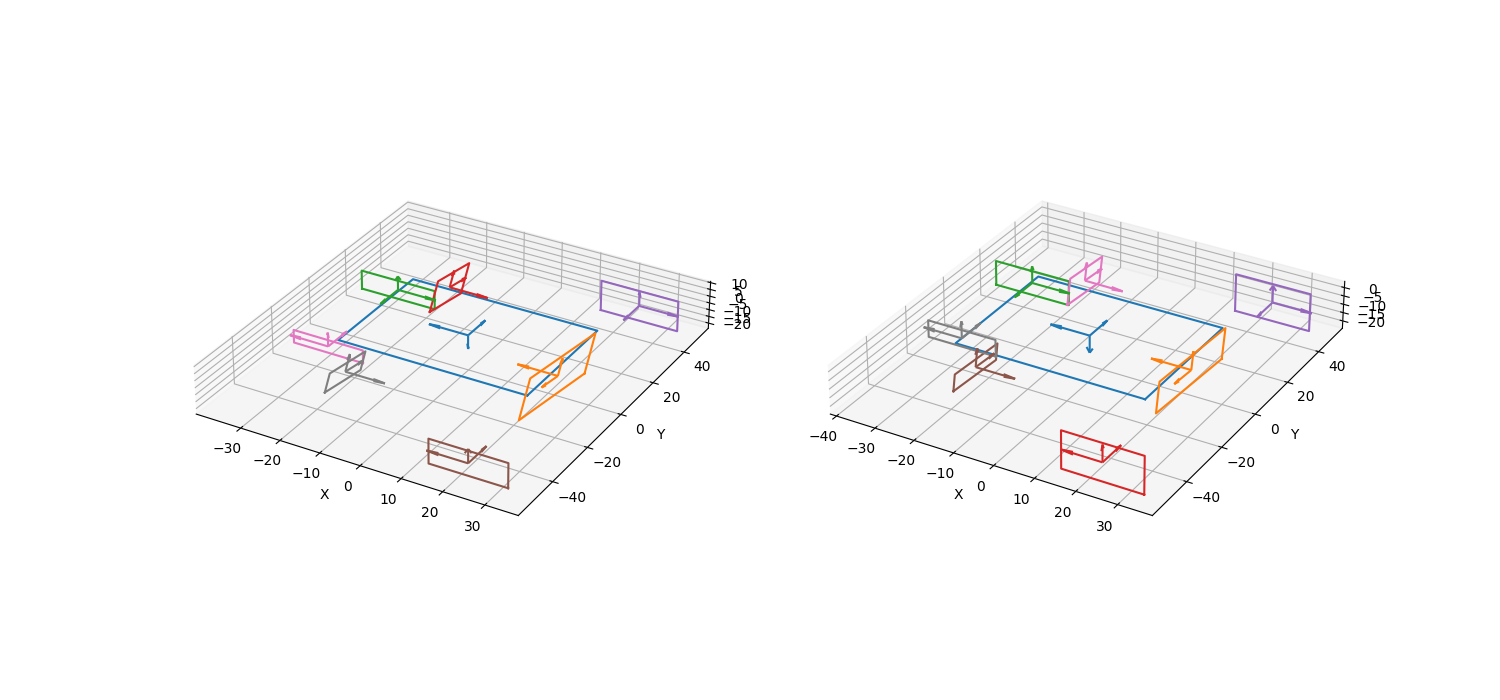

In [7]:
idx_1 = 1
idx_2 = 2

# Plot 2 scans
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax2.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

scans[idx_1].plot(ax1, show_normals=False)
scans[idx_2].plot(ax2, show_normals=False)

In [8]:
merge = scans[idx_1].merge(scans[idx_2])

vertex and face generation not yet implemented


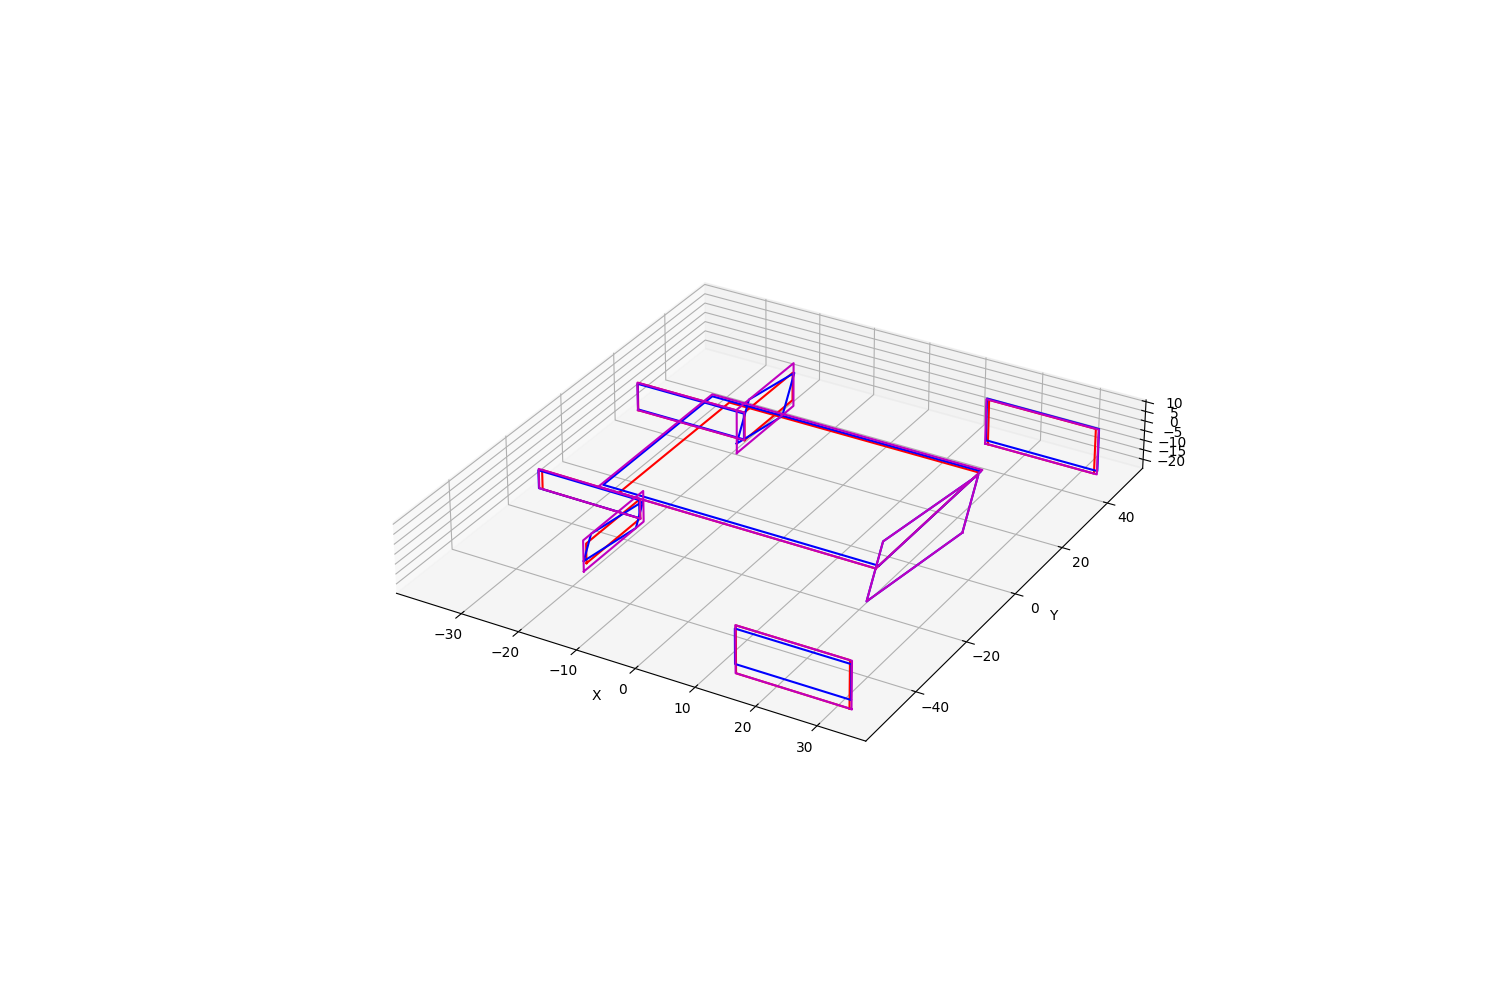

In [11]:
# Plot merge
ax = plot_3D_setup(PC_data[0])

scans[idx_1].plot(ax, color='r', show_normals=False)
scans[idx_2].plot(ax, color='b', show_normals=False)

merge.plot(ax, color='m', show_normals=False)

In [8]:
merged = scans[0]

for s in scans[1:]:
    merged = merged.merge(s)

vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and face generation not yet implemented
vertex and fa

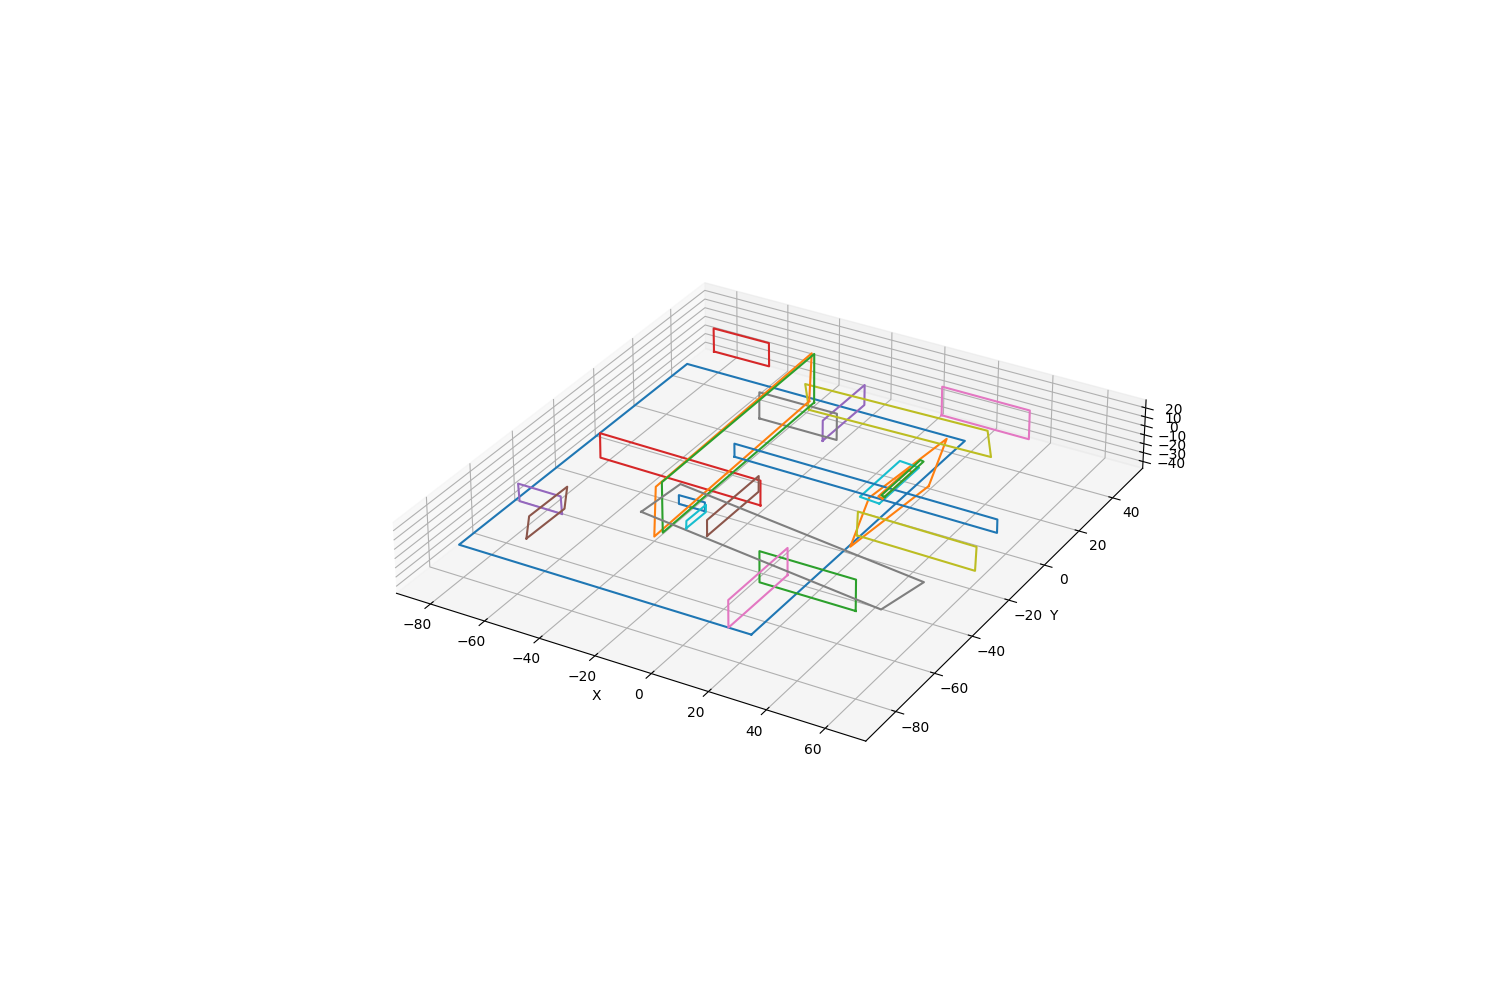

In [9]:
# Plot merge
ax = plot_3D_setup(PC_data[0])
merged.plot(ax)